## Анализ временных рядов и предсказание количества поездок на неделю вперед

В этом ноутбуке данные группируется по количеству поездок за день, проводится анализ полученного временного ряда, делаются предсказания количества поездок на неделю вперед.

In [75]:
import scipy as sps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error as MSE

import plotly.graph_objects as go
import plotly.express as px
import plotly.offline

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
import gc
#from fbprophet import Prophet

import warnings

warnings.filterwarnings('ignore')
sns.set(font_scale=1.5)

Загрузим данные о поездках.

In [2]:
trips = pd.read_csv('cycle-share-dataset/trip.csv', error_bad_lines=False,
                   parse_dates=[1, 2])

b'Skipping line 50794: expected 12 fields, saw 20\n'


In [3]:
trips.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0
3,434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0
4,435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0


## Глава 1. Анализ временных рядов

### 1. Кол-во поездок в зависимости от даты

Отобразим количество поездок в зависимости от даты.

Преобразуем сначала данные для удобства подсчёта.

In [12]:
time_data = trips[['trip_id', 'starttime', 'stoptime']].copy()

time_data['start_year'] = time_data['starttime'].dt.year
time_data['start_month'] = time_data['starttime'].dt.month
time_data['start_day'] = time_data['starttime'].dt.day
time_data['start_date'] = time_data['starttime'].dt.date
time_data['start_time'] = time_data['starttime'].dt.time
time_data['start_weekday'] = time_data['starttime'].dt.dayofweek

time_data['stop_year'] = time_data['stoptime'].dt.year
time_data['stop_month'] = time_data['stoptime'].dt.month
time_data['stop_day'] = time_data['stoptime'].dt.day
time_data['stop_date'] = time_data['stoptime'].dt.date
time_data['stop_time'] = time_data['stoptime'].dt.time
time_data['stop_weekday'] = time_data['stoptime'].dt.dayofweek

time_data.drop(columns=['starttime', 'stoptime'], inplace=True)

time_data.head()

,trip_id,start_year,start_month,start_day,start_date,start_time,start_weekday,stop_year,stop_month,stop_day,stop_date,stop_time,stop_weekday
0,431,2014,10,13,2014-10-13,10:31:00,0,2014,10,13,2014-10-13,10:48:00,0
1,432,2014,10,13,2014-10-13,10:32:00,0,2014,10,13,2014-10-13,10:48:00,0
2,433,2014,10,13,2014-10-13,10:33:00,0,2014,10,13,2014-10-13,10:48:00,0
3,434,2014,10,13,2014-10-13,10:34:00,0,2014,10,13,2014-10-13,10:48:00,0
4,435,2014,10,13,2014-10-13,10:34:00,0,2014,10,13,2014-10-13,10:49:00,0


In [13]:
trips_by_date = time_data.groupby('start_date').count()['trip_id']

trips_by_date

start_date
2014-10-13    818
2014-10-14    982
2014-10-15    626
2014-10-16    790
2014-10-17    588
             ... 
2016-08-27    333
2016-08-28    392
2016-08-29    369
2016-08-30    375
2016-08-31    319
Name: trip_id, Length: 689, dtype: int64

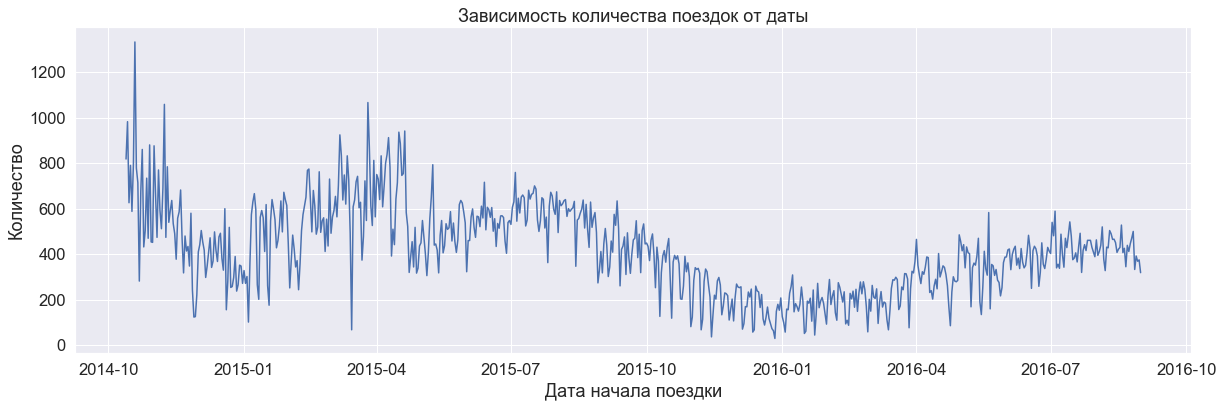

In [14]:
plt.figure(figsize=(20, 6))
sns.set_style('darkgrid')

plt.title('Зависимость количества поездок от даты')

plt.plot(trips_by_date.index, trips_by_date)
plt.xlabel('Дата начала поездки')
plt.ylabel('Количество')

plt.show()

**Наблюдения:** видно что в зависимости от даты у кол-ва поездок меняется дисперсия. Также на многих промежутках времени явно прослеживается тренд, поэтому скорее всего ряд не стационарен

### 2. Стационарность

Проверим ряд на стационарность с помощью критерия KPSS.

In [15]:
kpss(trips_by_date)

(1.5432360160081644,
 0.01,
 20,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

***Наблюдение***

Гипотеза о стационарности отверглась. Значит, имеет смысл исследовать ряд на тренд и сезонность. 

### 3. STL-декомпозиция

Применим STL-декомпозицию к полученному временному ряду.

In [16]:
decomposed = seasonal_decompose(trips_by_date, freq=30)

day_decomp = seasonal_decompose(trips_by_date, freq=7)

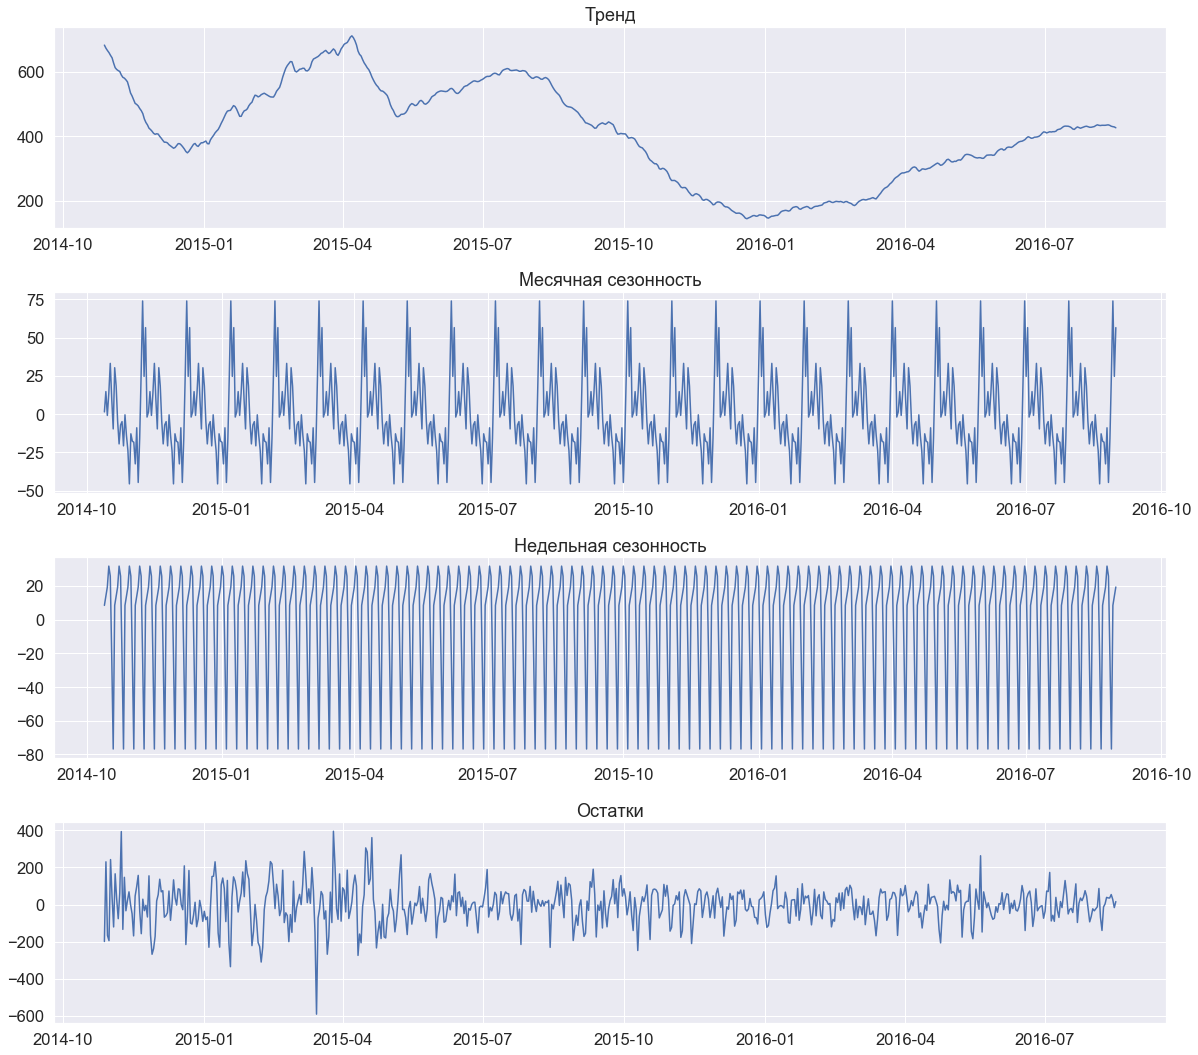

In [17]:
plt.figure(figsize=(17, 15))

plt.subplot(411)
plt.plot(trips_by_date.index, decomposed.trend)
plt.title('Тренд')

plt.subplot(412)
plt.plot(trips_by_date.index, decomposed.seasonal)
plt.title('Месячная сезонность')

plt.subplot(413)
plt.plot(trips_by_date.index, day_decomp.seasonal)
plt.title('Недельная сезонность')

plt.subplot(414)
plt.plot(trips_by_date.index, decomposed.resid)
plt.title('Остатки')

plt.tight_layout()

***Наблюдение***


На графиках отчётливо прослеживается недельная и месячная сезонность. Исследовать годовую сезоннность с помощью декомпозиции не представляется возможным, т.к. в датасете нет данных за полных два года.

### 4. Автокорреляция

Построим теперь графики автокорреляций для продифференцированного ряда, т.к. в данных, очевидно, наблюдается и тренд, и сезонность.

Для удаления тренда и всех сезонностей продифференцируем ряд несколько раз.

In [18]:
diff =  trips_by_date.values[1:] - trips_by_date.values[:-1]
month_diff = diff[30:] - diff[:-30]
week_diff = month_diff[7:] - month_diff[:-7]

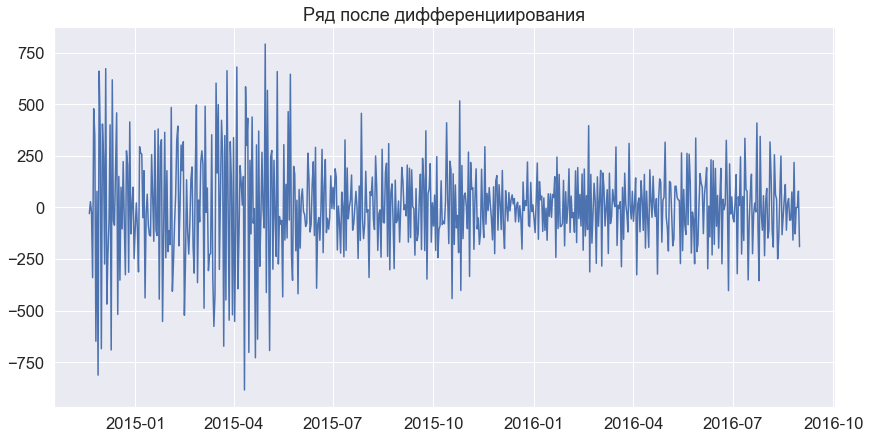

In [19]:
plt.figure(figsize=(14, 7))
plt.title('Ряд после дифференциирования')
plt.plot(trips_by_date.index.values[38:], week_diff)
plt.show()

**Наблюдение:** тренд и сезонность кажется убраны, но дисперсия все равно не стабильна.

Проверим гипотезу о стационариности.

In [20]:
kpss(week_diff)

(0.02203749101702757,
 0.1,
 20,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Как видим теперь гипотеза о стационарности не отвергается

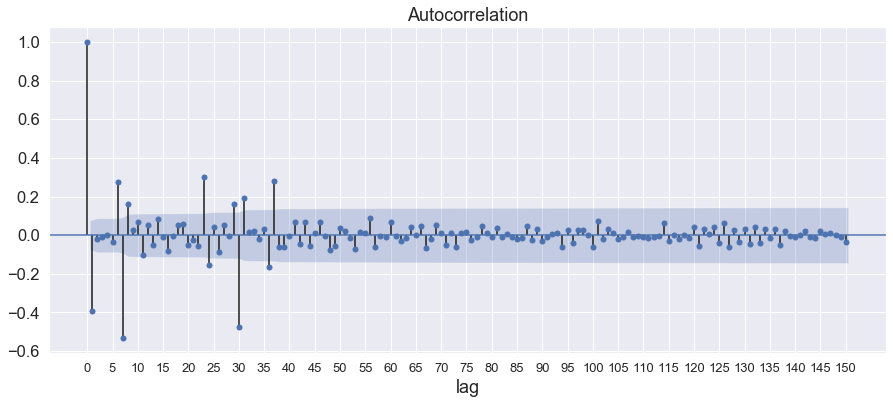

In [21]:
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(week_diff, lags=150, ax=ax)
ax.set_xticks(np.arange(0, 151, 5))

plt.setp(ax.get_xticklabels(), fontsize=13)
ax.set_xlabel('lag')

plt.show()

***Вывод***

Значимыми оказались лаги 1, 6, 7, 23, 24, 30, 36, 37. Значения 7 и 30 учитывать не стоит, т.к. дифференцирование могло "снять" не всю сезонность. Остальные результаты помогут в подборе параметров предсказательных моделей. Таких, как, например, ARIMA.

## Глава 2. Предсказание поездок на неделю вперёд

### 0. Разбиение данных

Разобьем поездки на интервалы по 30 минут.

In [22]:
time_data.head()

,trip_id,start_year,start_month,start_day,start_date,start_time,start_weekday,stop_year,stop_month,stop_day,stop_date,stop_time,stop_weekday
0,431,2014,10,13,2014-10-13,10:31:00,0,2014,10,13,2014-10-13,10:48:00,0
1,432,2014,10,13,2014-10-13,10:32:00,0,2014,10,13,2014-10-13,10:48:00,0
2,433,2014,10,13,2014-10-13,10:33:00,0,2014,10,13,2014-10-13,10:48:00,0
3,434,2014,10,13,2014-10-13,10:34:00,0,2014,10,13,2014-10-13,10:48:00,0
4,435,2014,10,13,2014-10-13,10:34:00,0,2014,10,13,2014-10-13,10:49:00,0


In [23]:
def time_round(s):
    if int(s[0]) >= 3:
        return '30'
    else:
        return '00'

time_data.start_time = time_data.start_time.values.astype(str)
time_data['time'] = [str(day) + ' ' + s[0:3] + time_round(s[3:4]) + ':00' 
                     for s, day in zip(time_data.start_time.values, time_data.start_date.values)]

In [24]:
time_data['time'] = [pd.to_datetime(s) for s in time_data.time.values]

In [25]:
series = time_data.groupby('time').count()['trip_id'].to_frame()

In [26]:
series['count'] = series.trip_id
series = series.drop(columns=['trip_id'])

In [29]:
series

,count
time,
2014-10-13 10:30:00,12
2014-10-13 11:30:00,108
2014-10-13 12:00:00,42
2014-10-13 12:30:00,42
2014-10-13 13:00:00,36
...,...
2016-08-31 21:00:00,3
2016-08-31 21:30:00,2
2016-08-31 22:00:00,4


Будем предсказывать кол-во взятых в прокат велосипедов на неделю вперед по данным за последние полгода. Понятно, что так мы сможем учесть и месячную, и недельную сезонность, в то же время мы не можем ничего говорить о годовой сезонности, поэтому данные почти за два года будут излишними, более того, из-за них можно будет не уследить за краткосрочным трендом.

In [30]:
test_size = 48*7
train_size = 48*30*3
train = series.tail(test_size + train_size).head(train_size)
test = series.tail(test_size)

In [31]:
train.to_csv('train_ts.csv')
test.to_csv('test_ts.csv')

Взглянем на ряд

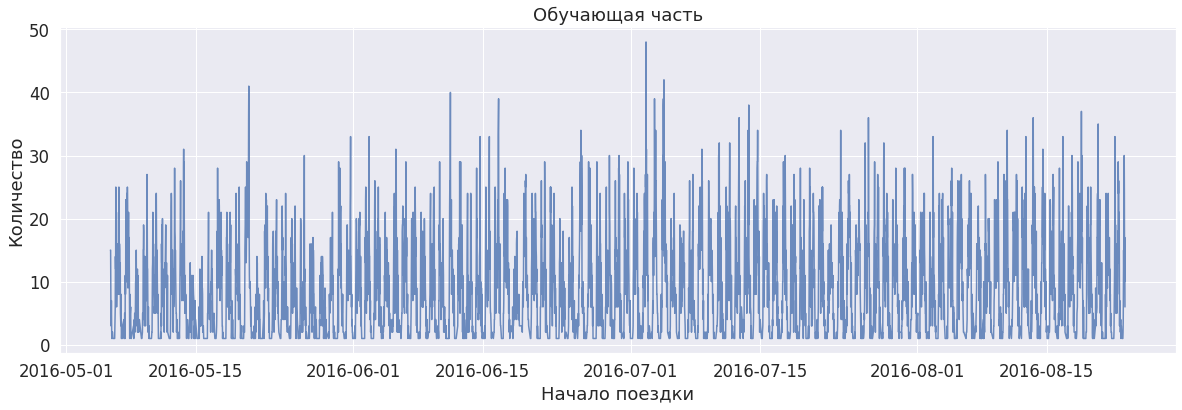

In [13]:
plt.figure(figsize=(20, 6))
sns.set_style('darkgrid')

plt.title('Обучающая часть')

plt.plot(train.index, train['count'].values, alpha=0.8)
plt.xlabel('Начало поездки')
plt.ylabel('Количество')

plt.show()

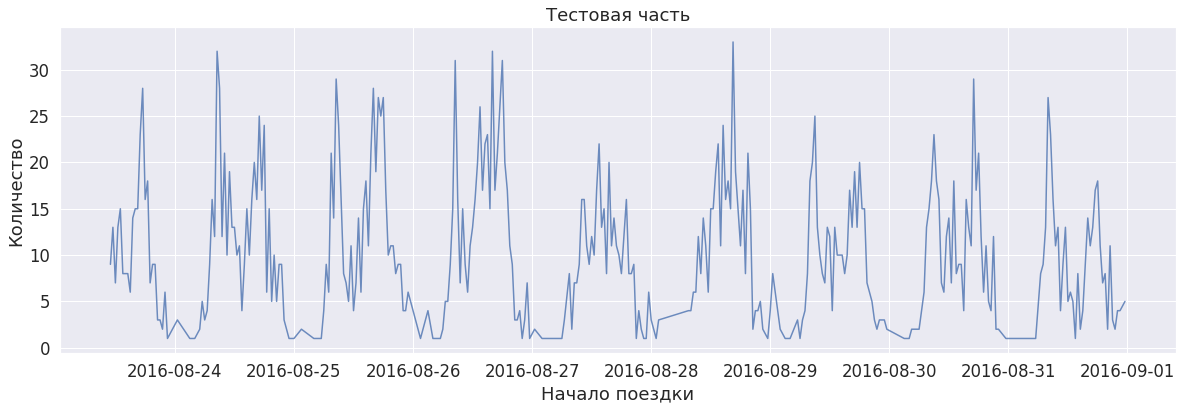

In [14]:
plt.figure(figsize=(20, 6))
sns.set_style('darkgrid')

plt.title('Тестовая часть')

plt.plot(test.index, test['count'].values, alpha=0.8)
plt.xlabel('Начало поездки')
plt.ylabel('Количество')

plt.show()

### 1. Бейзлайны - среднее и последнее наблюдаемое значение.

Во временных рядах сильными бейзлайнами являются среднеее и последнее наблюдаемое значение. Благодаря ним поймем, на какой MSE стоит ориентироваться.

In [0]:
mean_preds = np.array([train['count'].mean()] * test_size)

In [79]:
def print_preds(test, preds, name):
    plt.figure(figsize=(20, 6))
    sns.set_style('darkgrid')

    plt.title('Тестовая часть и предсказания')

    plt.plot(test.index, test['count'].values, alpha=0.8,
             label='test')
    plt.plot(test.index, preds, alpha=0.9,
             label=name + ' preds')
    plt.xlabel('Начало поездки')
    plt.ylabel('Количество')
    plt.legend()
    plt.show()

MSE = 54.57371512468156


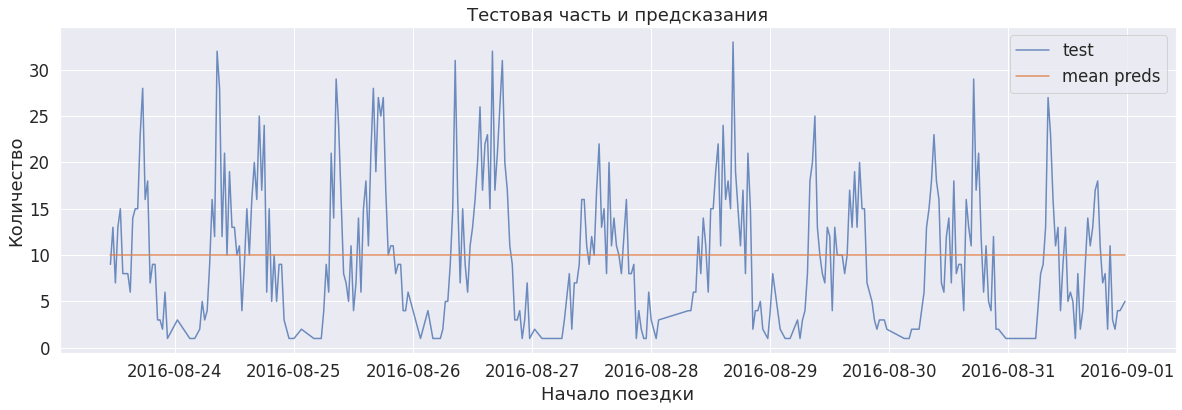

In [17]:
mse = MSE(test['count'].values, mean_preds)
print(f'MSE = {mse}')
print_preds(test, mean_preds, name='mean')

MSE = 72.96130952380952


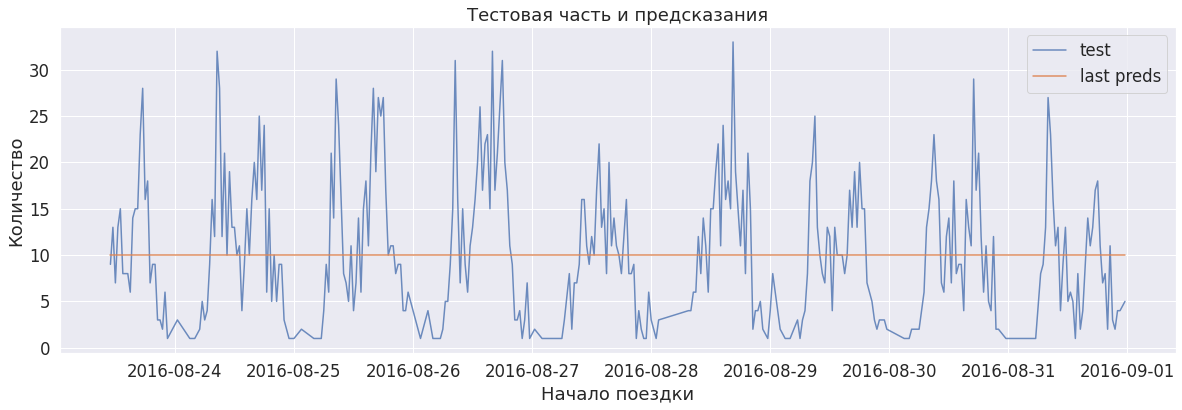

In [18]:
last_preds = np.array([train['count'].values[-1]] * test_size)
mse = MSE(test['count'].values, last_preds)
print(f'MSE = {mse}')
print_preds(test, mean_preds, name='last')

Пока будем равняться на бейзлайн средних предсказаний

### 2. Подбор параметров для SARIMA

Из анализа проведенного выше понятно, что есть месячная и недельная сезонность. Рассмотрим дневную.

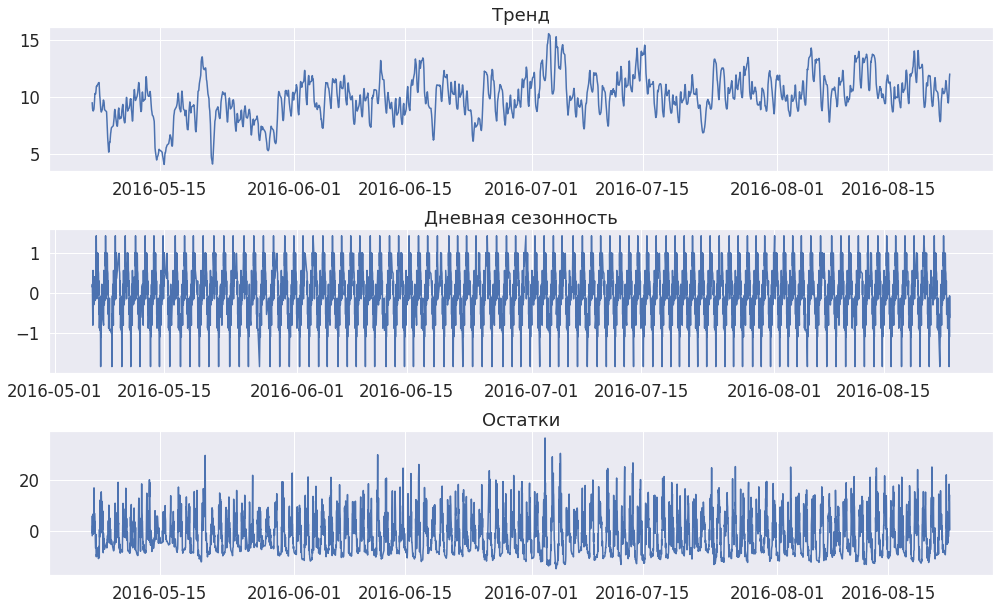

In [19]:
gc.collect()
decomposed = seasonal_decompose(train['count'].values, freq=48)

plt.figure(figsize=(14, 11))

plt.subplot(411)
plt.plot(train.index, decomposed.trend)
plt.title('Тренд')

plt.subplot(412)
plt.plot(train.index, decomposed.seasonal)
plt.title('Дневная сезонность')

plt.subplot(413)
plt.plot(train.index, decomposed.resid)
plt.title('Остатки')

plt.tight_layout()

Дневная сезонность действительно очевидна.

Для подбора параметров для SARIMA нужно смотреть на значимые лаги коррелограммы после приведения ряда к стационарному.

In [0]:
train_count = train['count'].values

In [21]:
kpss(train_count)

(1.735283654917425,
 0.01,
 31,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Как видим, пока что гипотеза о стационарности отвергается

In [0]:
diff = train_count[1:] - train_count[:(-1)]  # снимаем тренд
diff = diff[(48*30):] - diff[:(-48*30)]
diff = diff[(48*7):] - diff[:(-48*7)]
diff = diff[(48):] - diff[:(-48)]

In [23]:
kpss(diff)

(0.0047162543491004235,
 0.1,
 27,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Теперь не отвергается

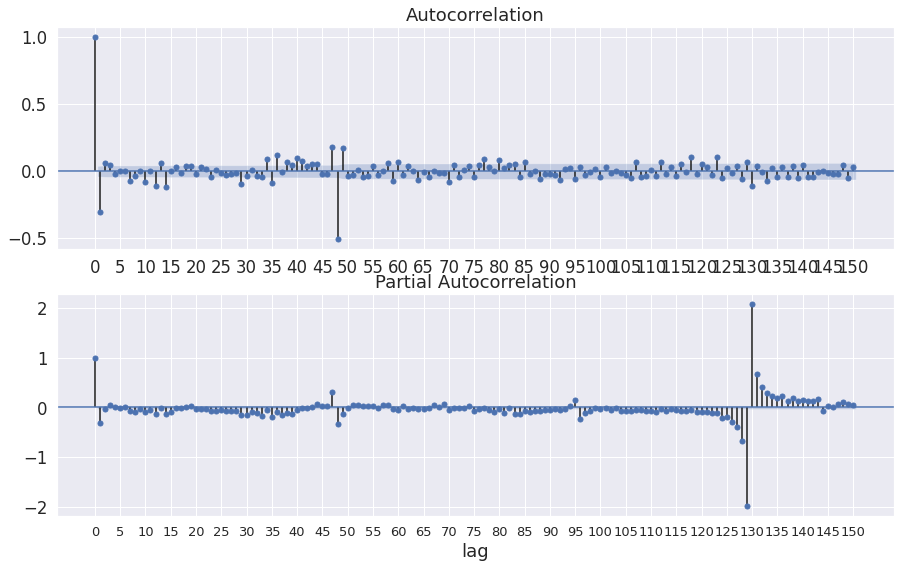

In [24]:
fig = plt.figure(figsize=(15, 9))

ax = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff, lags=150, ax=ax)
ax.set_xticks(np.arange(0, 151, 5))

ax = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff, lags=150, ax=ax)
ax.set_xticks(np.arange(0, 151, 5))

plt.setp(ax.get_xticklabels(), fontsize=13)
ax.set_xlabel('lag')

plt.show()

**Результат:** автокорреляция принимает большие значения для первых 2-х лагов, поэтому
возьмем p = 2. Частичная автокоррреляция принимает большие значения для первых трех
лагов, поэтому возьмем q = 3. На лаги, соответствующие сезонности, не обращаем внимание, так как дифференциируемость не обязательнос снимает всю сезонность.

### 3. Обучение SARIMAX

In [25]:
%%time
param = (2, 1, 3)
param_seasonal = (2, 1, 2, 48)
model = sm.tsa.statespace.SARIMAX(train_count, order=param,
                                  seasonal_order=param_seasonal)
model = model.fit()
print('ARIMA{}x{} – AIC: {:.2f}'.format(param,
                                        param_seasonal,
                                        model.aic))

ARIMA(2, 1, 3)x(2, 1, 2, 48) – AIC: 26330.06
CPU times: user 2h 17min 32s, sys: 1h 16min 14s, total: 3h 33min 47s
Wall time: 54min 2s


In [0]:
preds = model.forecast(steps=48*7)

MSE = 56.70103145859546


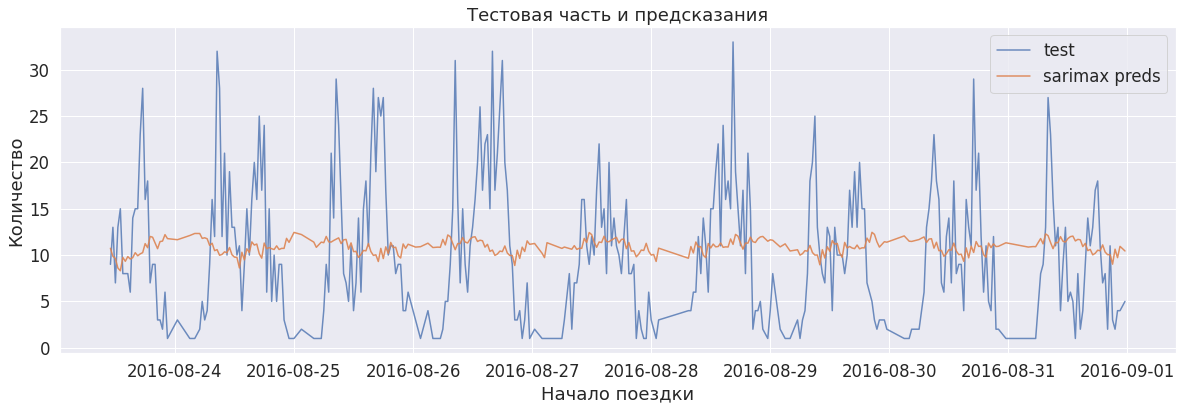

In [27]:
mse = MSE(test['count'].values, preds)
print(f'MSE = {mse}')
print_preds(test, preds, name='sarimax')

**Результат:** SARIMAX плохо справляется, результат даже хуже среднего

### 4. fb prophet

In [0]:
from fbprophet import Prophet

In [41]:
train.head()

,count
time,
2016-05-05 18:30:00,15
2016-05-05 19:00:00,15
2016-05-05 19:30:00,10
2016-05-05 20:00:00,3
2016-05-05 20:30:00,4


In [0]:
train_for_prophet = train.reset_index()
train_for_prophet.columns = ['ds', 'y']

In [43]:
train_for_prophet.head()

,ds,y
0,2016-05-05 18:30:00,15
1,2016-05-05 19:00:00,15
2,2016-05-05 19:30:00,10
3,2016-05-05 20:00:00,3
4,2016-05-05 20:30:00,4


In [44]:
m = Prophet()
m.fit(train_for_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [0]:
future = m.make_future_dataframe(periods=48*7)
forecast = m.predict(future)

In [0]:
preds = forecast['yhat'].values

MSE = 103.9387186843022


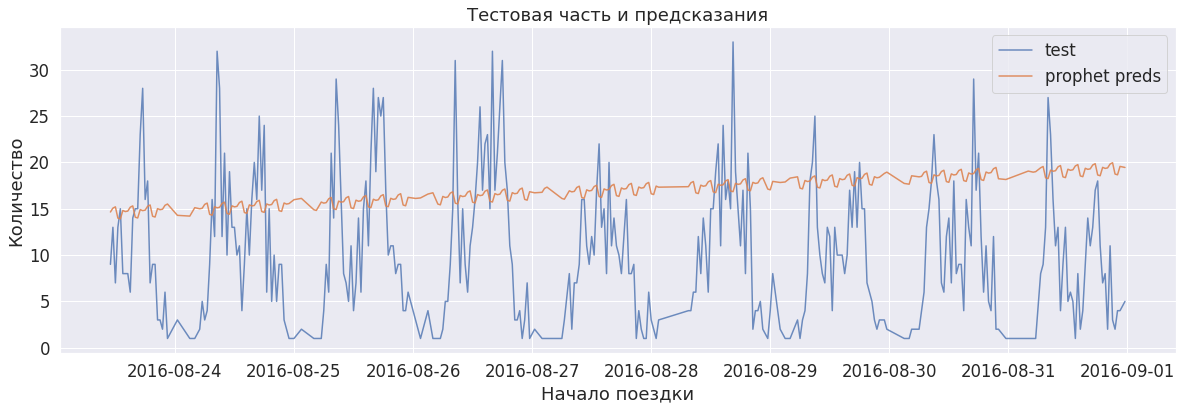

In [62]:
mse = MSE(test['count'].values, preds[-48*7:])
print(f'MSE = {mse}')
print_preds(test, preds[-48*7:], name='prophet')

**Результат:** prophet справляется совсем плохо

### 5. Экзогенные факторы.

Для этого скачаем данные о погодных условиях.

In [54]:
weather_data = pd.read_csv('cycle-share-dataset/weather.csv',
                           parse_dates=[0], na_values='-')

weather_data.head()

,Date,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,...,Mean_Sea_Level_Pressure_In,Min_Sea_Level_Pressure_In,Max_Visibility_Miles,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Max_Gust_Speed_MPH,Precipitation_In,Events
0,2014-10-13,71,62.0,54,55,51,46,87,68,46,...,29.79,29.65,10,10,4,13,4,21.0,0.00,Rain
1,2014-10-14,63,59.0,55,52,51,50,88,78,63,...,29.75,29.54,10,9,3,10,5,17.0,0.11,Rain
2,2014-10-15,62,58.0,54,53,50,46,87,77,67,...,29.71,29.51,10,9,3,18,7,25.0,0.45,Rain
3,2014-10-16,71,61.0,52,49,46,42,83,61,36,...,29.95,29.81,10,10,10,9,4,NaN,0.00,Rain
4,2014-10-17,64,60.0,57,55,51,41,87,72,46,...,29.78,29.73,10,10,6,8,3,NaN,0.14,Rain


При анализе влияния погодных условий на количесво поездок мы получили, что значимыми являются такие показатели, как температура, влажность и точка росы.

Добавим их в нашу модель.

Добавим, сначала, в наш временной ряд признак даты

In [55]:
series_w_date = series.reset_index()
series_w_date['date'] = series_w_date.time.dt.normalize()

series_w_date.head()

,time,count,date
0,2014-10-13 10:30:00,12,2014-10-13
1,2014-10-13 11:30:00,108,2014-10-13
2,2014-10-13 12:00:00,42,2014-10-13
3,2014-10-13 12:30:00,42,2014-10-13
4,2014-10-13 13:00:00,36,2014-10-13


In [56]:
weather_signif = weather_data.loc[:, ['Date', 'Mean_Temperature_F',
                                      'MeanDew_Point_F', 'Mean_Humidity']].copy()

Теперь, соединим две таблицы.

In [57]:
series_exog = series_w_date.merge(weather_signif, how='left',
                                    left_on='date', right_on='Date')

series_exog.head()

,time,count,date,Date,Mean_Temperature_F,MeanDew_Point_F,Mean_Humidity
0,2014-10-13 10:30:00,12,2014-10-13,2014-10-13,62.0,51,68
1,2014-10-13 11:30:00,108,2014-10-13,2014-10-13,62.0,51,68
2,2014-10-13 12:00:00,42,2014-10-13,2014-10-13,62.0,51,68
3,2014-10-13 12:30:00,42,2014-10-13,2014-10-13,62.0,51,68
4,2014-10-13 13:00:00,36,2014-10-13,2014-10-13,62.0,51,68


In [64]:
series_exog.to_csv('series_exog.csv')

Разделим временной ряд на обучающую и тестовую выборки.

In [70]:
test_size = 48*7
train_size = 48*30*3
train_exog = series_exog.tail(test_size + train_size).head(train_size)
test_exog = series_exog.tail(test_size)

In [71]:
train_count = train_exog['count'].values
test_count = test_exog['count'].values

exog = train_exog.loc[:,['Mean_Temperature_F',
                         'MeanDew_Point_F',
                         'Mean_Humidity']].values

Обучим модель с подобранными ранее параметрами и добавлением данных о погоде, как экзогенного фактора.

In [65]:
%%time
param = (2, 1, 3)
param_seasonal = (2, 1, 2, 48)
model = sm.tsa.statespace.SARIMAX(train_count, order=param,
                                  seasonal_order=param_seasonal,
                                  exog=exog)
model = model.fit()
print('ARIMA{}x{} – AIC: {:.2f}'.format(param,
                                        param_seasonal,
                                        model.aic))

ARIMA(2, 1, 3)x(2, 1, 2, 48) – AIC: 26379.94
CPU times: user 1h 17min 44s, sys: 28.9 s, total: 1h 18min 13s
Wall time: 19min 55s


Предсказание модели.

In [95]:
test_exog_values = test_exog.loc[:,['Mean_Temperature_F',
                         'MeanDew_Point_F',
                         'Mean_Humidity']].values

preds_exog = model.forecast(steps=48*7, exog=test_exog_values)

In [96]:
def print_preds_exog(test, exog, preds, name):
    plt.figure(figsize=(20, 12))
    sns.set_style('darkgrid')
    
    plt.subplot(211)
    plt.title('Тестовая часть и предсказания')

    plt.plot(test.index, test['count'].values, alpha=0.8,
             label='test')
    plt.plot(test.index, preds, alpha=0.9,
             label=name + ' preds')
        
    plt.xlabel('Начало поездки')
    plt.ylabel('Количество')
    plt.legend()
    
    plt.subplot(212)
    plt.title('Экзогенные факторы')
    for column in exog.columns:
        plt.plot(test.index, exog[column], label=column)
    plt.xlabel('Начало поездки')
    plt.legend()
    plt.tight_layout()

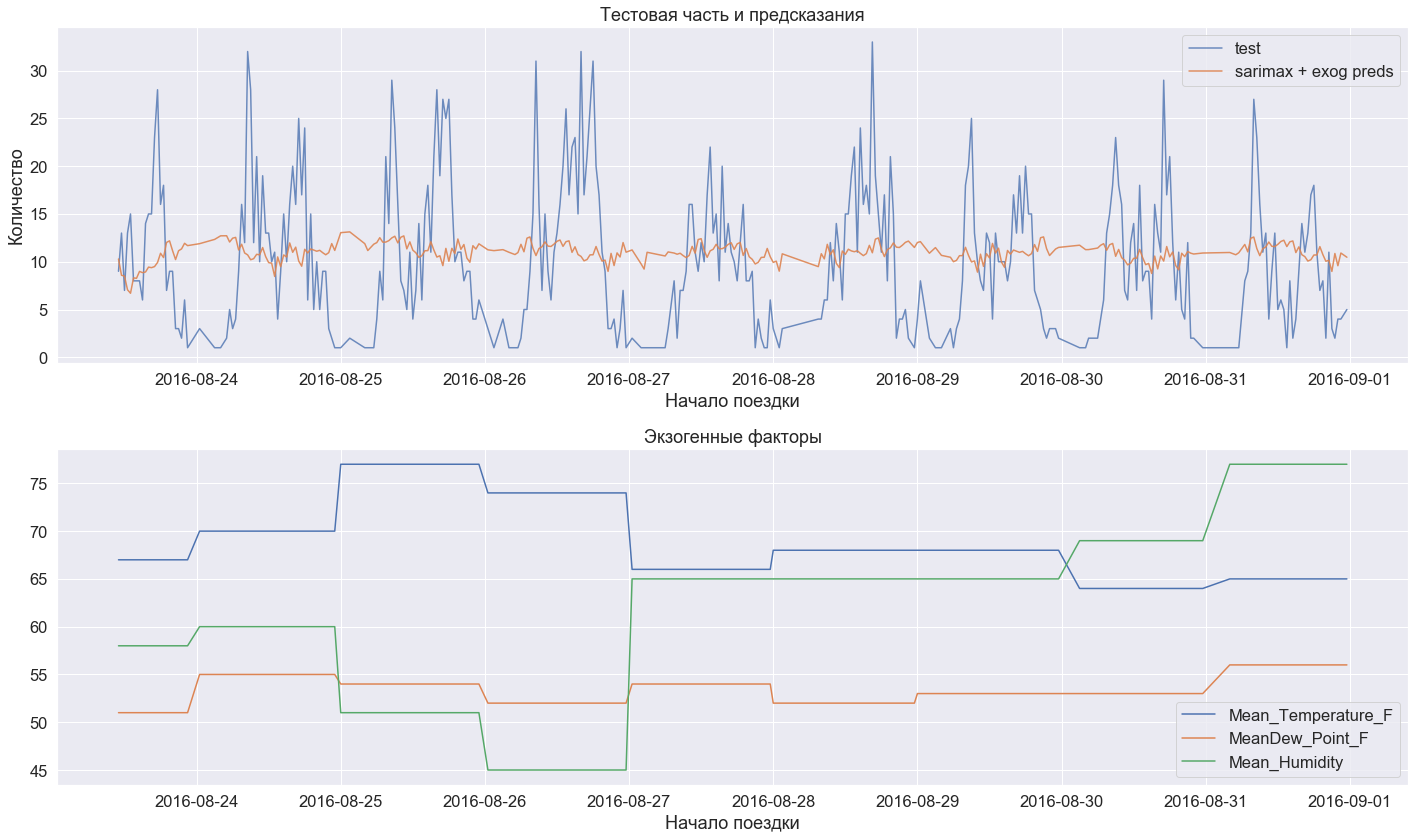

In [97]:
print_preds_exog(test,test_exog.loc[:,['Mean_Temperature_F',
                         'MeanDew_Point_F',
                         'Mean_Humidity']], preds_exog, name='sarimax + exog')

Качество MSE построенной модели.

In [99]:
mse = MSE(test_count, preds_exog)
print(f'MSE = {mse}')

MSE = 56.717890860833016


Таким образом, мы не смогли улучшить качество предсказания с помощью добавления экзогенных факторов погодных условий. 

Отдельно стоит отметить, что при использовании погодных условий, прежде чем предсказывать количество поездок, нужно отдельно предсказывать погоду на неделю вперёд, что вносит дополнительную ошибку, при условии, что мы не можем достаточно хорошо предсказывать погодные условия.

В качестве экзогенных факторов стоит добавить такие заранее предсказываемые признаки, как наличие праздника/выходного дня и т.д.